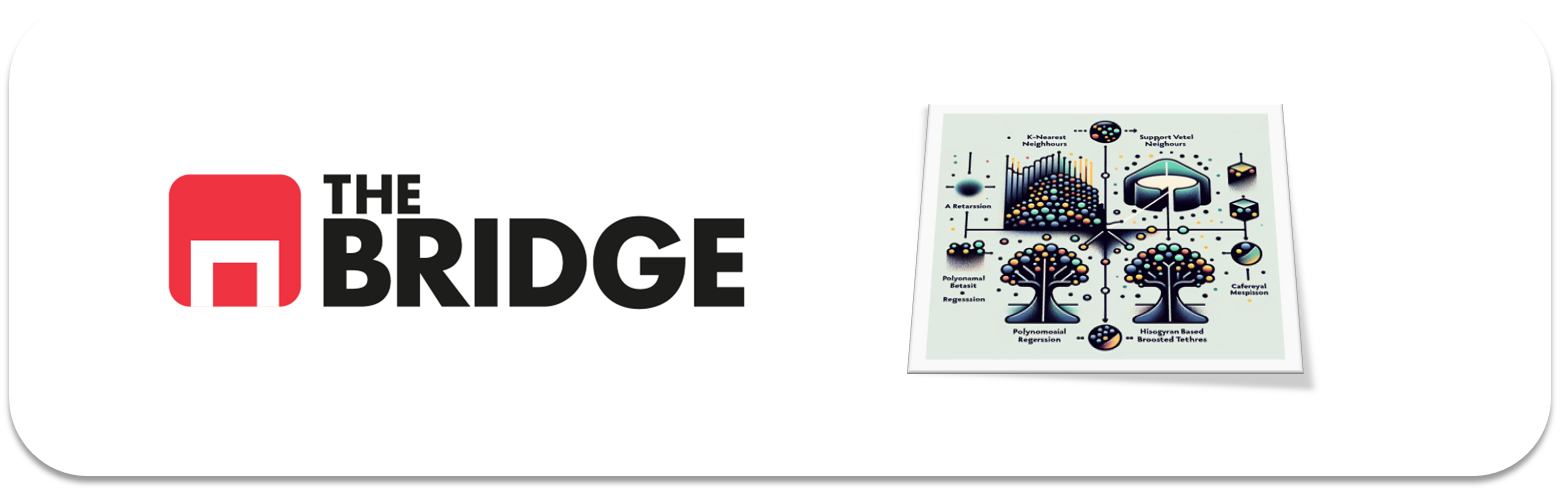

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [53]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades.

In [14]:
df = pd.read_csv('data/wines_dataset.csv', delimiter= '|')

In [15]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.5              0.21         0.26            9.25      0.034   
1            8.3              0.16         0.37            7.90      0.025   
2            6.8              0.18         0.38            1.40      0.038   
3            6.1              0.26         0.25            2.90      0.047   
4            7.5              0.63         0.27            2.00      0.083   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 73.0                 142.0  0.99450  3.05       0.37   
1                 38.0                 107.0  0.99306  2.93       0.37   
2                 35.0                 111.0  0.99180  3.32       0.59   
3                289.0                 440.0  0.99314  3.44       0.64   
4                 17.0                  91.0  0.99616  3.26       0.58   

   alcohol  quality  class  
0     11.4        6  white  
1     11.9        6  white  
2     11.2        7  white  
3     10.5        3  white  
4      9.8        6    red

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [25]:
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6497.000000  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801     5.818378  
std       0.160787     0.148806     1.192712     0.873255  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

In [20]:
target_c = 'class'
target_r = 'Alcohol'

## MINI EDA

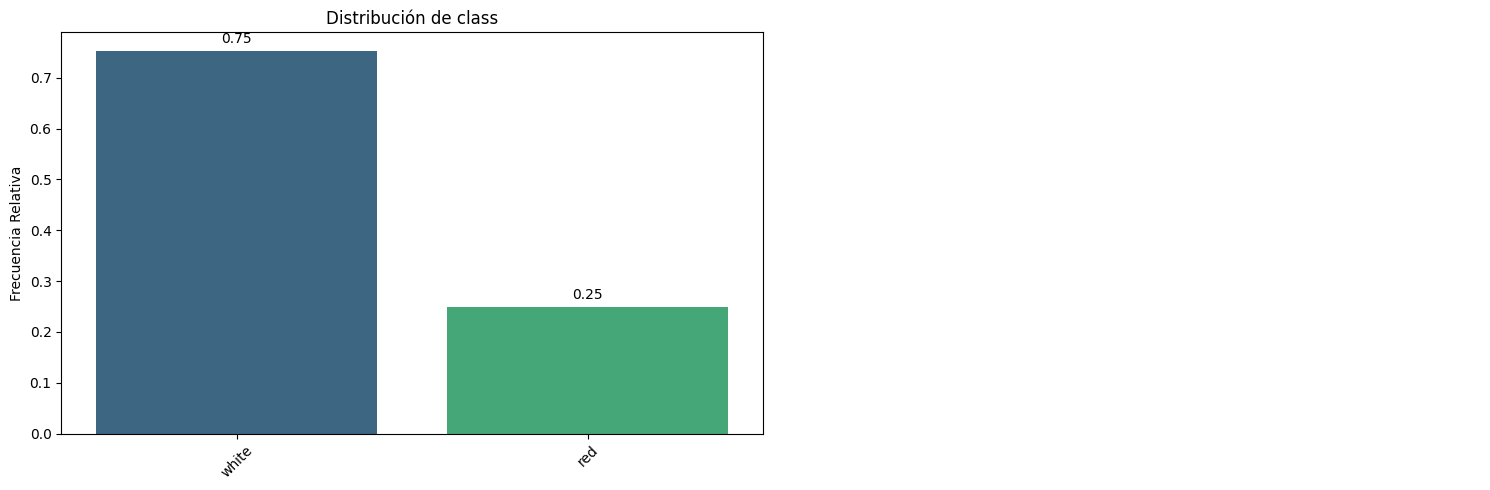

In [26]:
bt.pinta_distribucion_categoricas(train_set, [target_c], mostrar_valores= True, relativa= True)

In [28]:
features_num = train_set.columns.to_list()
features_num.remove(target_c) 

print(len(features_num))

12


In [37]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'class'],
      dtype='object')

In [39]:
features_1 = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides',
'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol', 'quality']

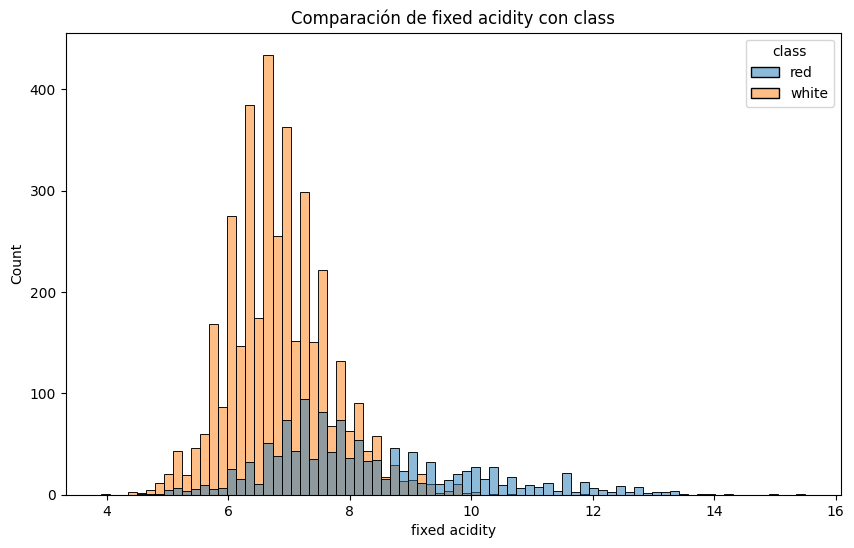

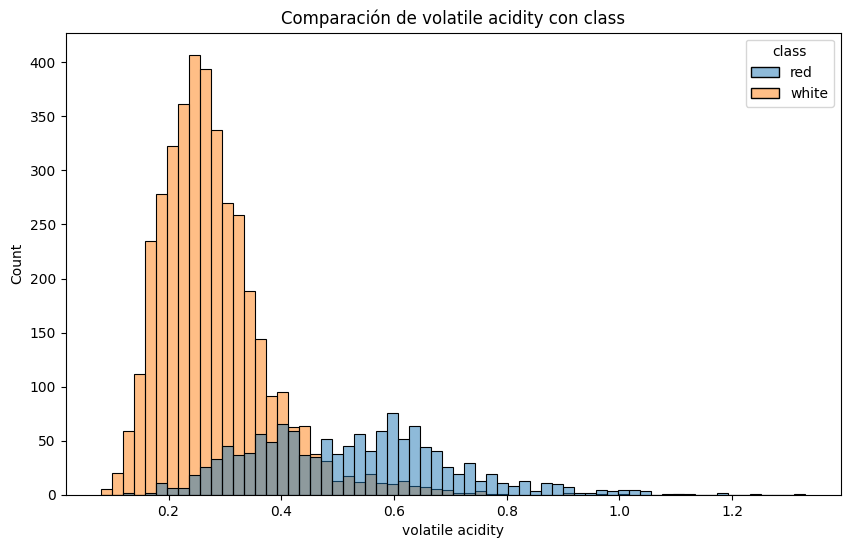

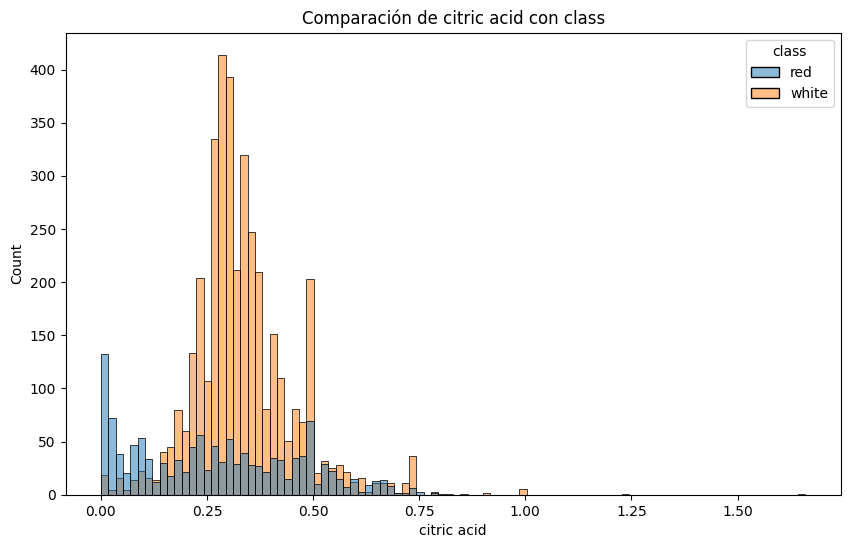

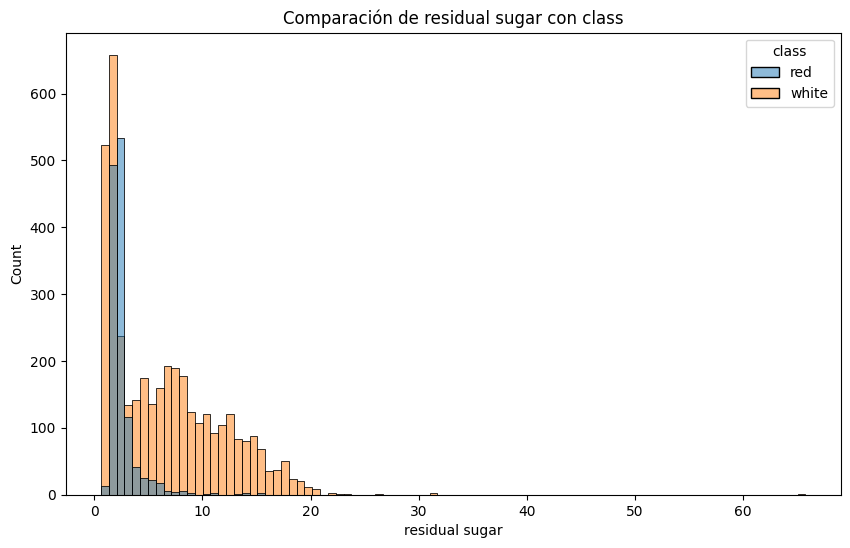

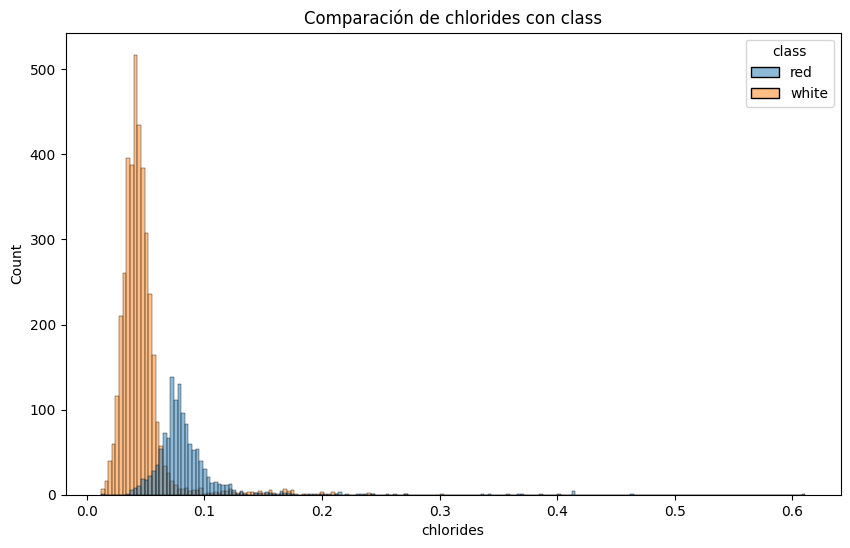

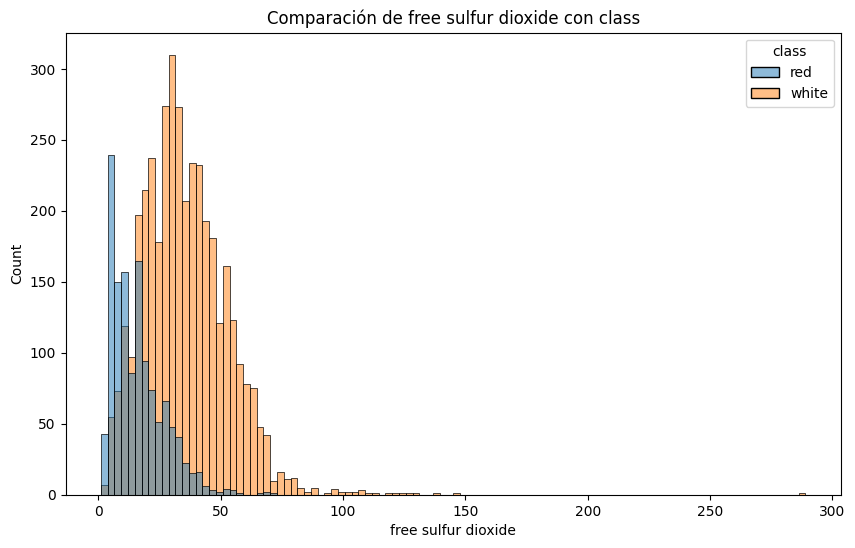

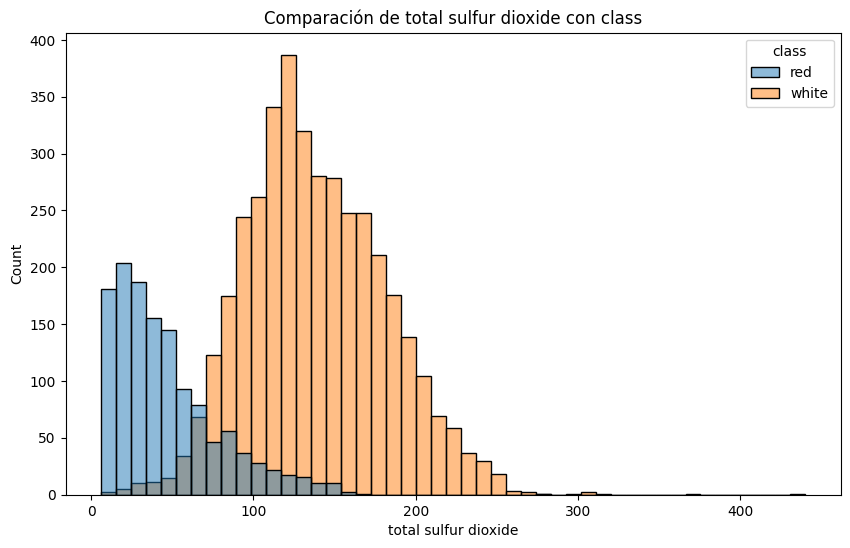

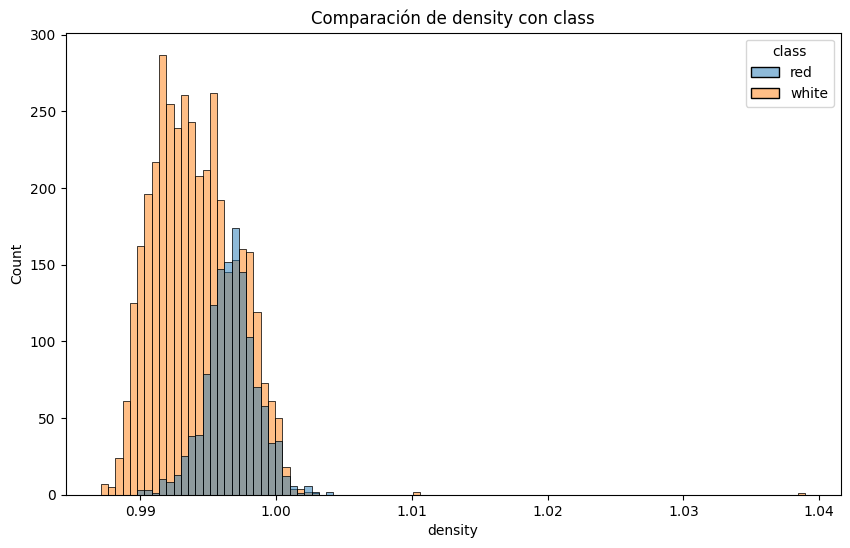

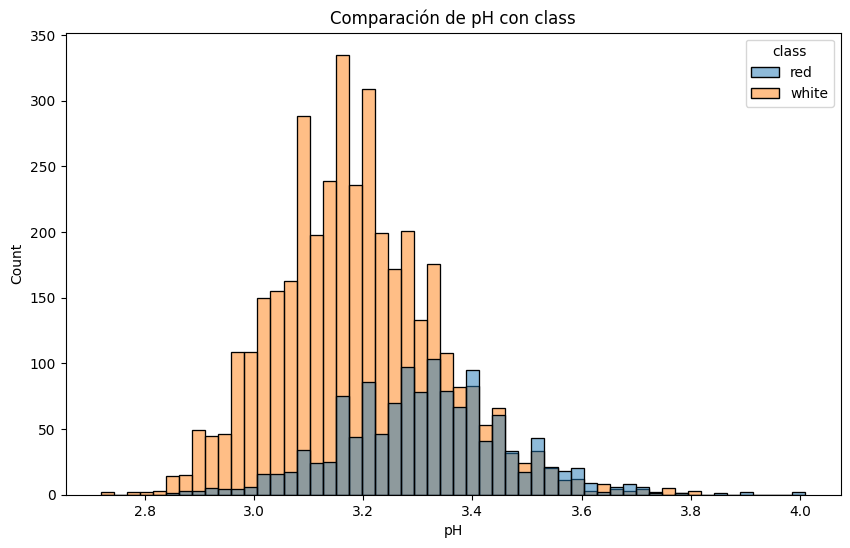

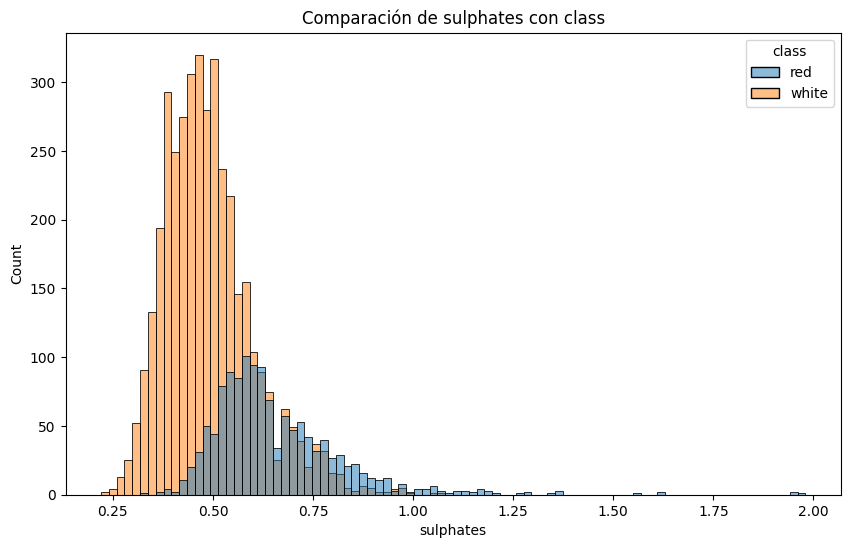

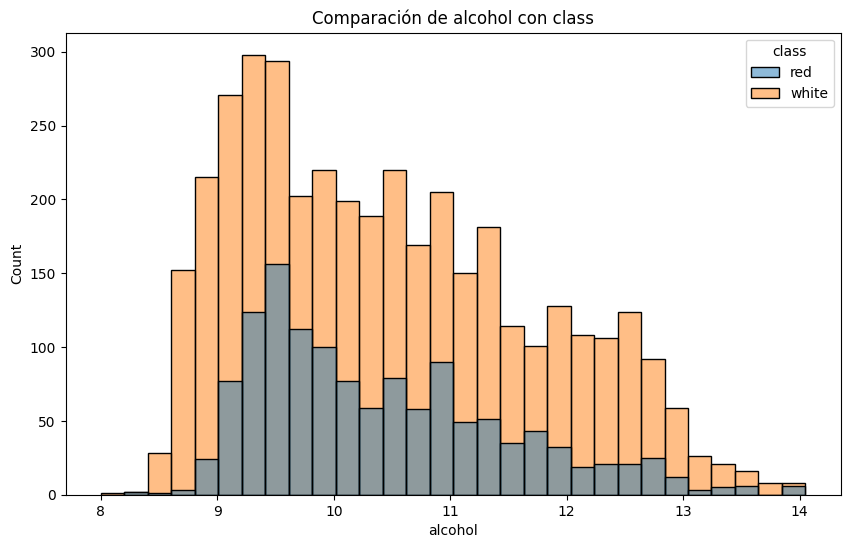

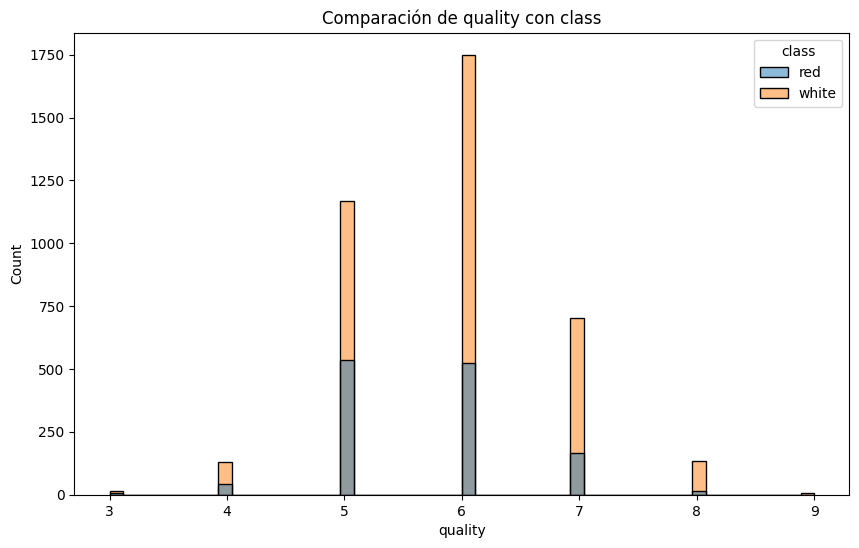

In [42]:
# Obtén una lista de todas las columnas del DataFrame excepto el target
columnas_features = [col for col in train_set.columns if col != target_c]

# Itera sobre las columnas y crea gráficos de barras para cada una
for columna in columnas_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(x=columna, hue=target_c, data=train_set)
    plt.title(f'Comparación de {columna} con {target_c}')
    plt.show()


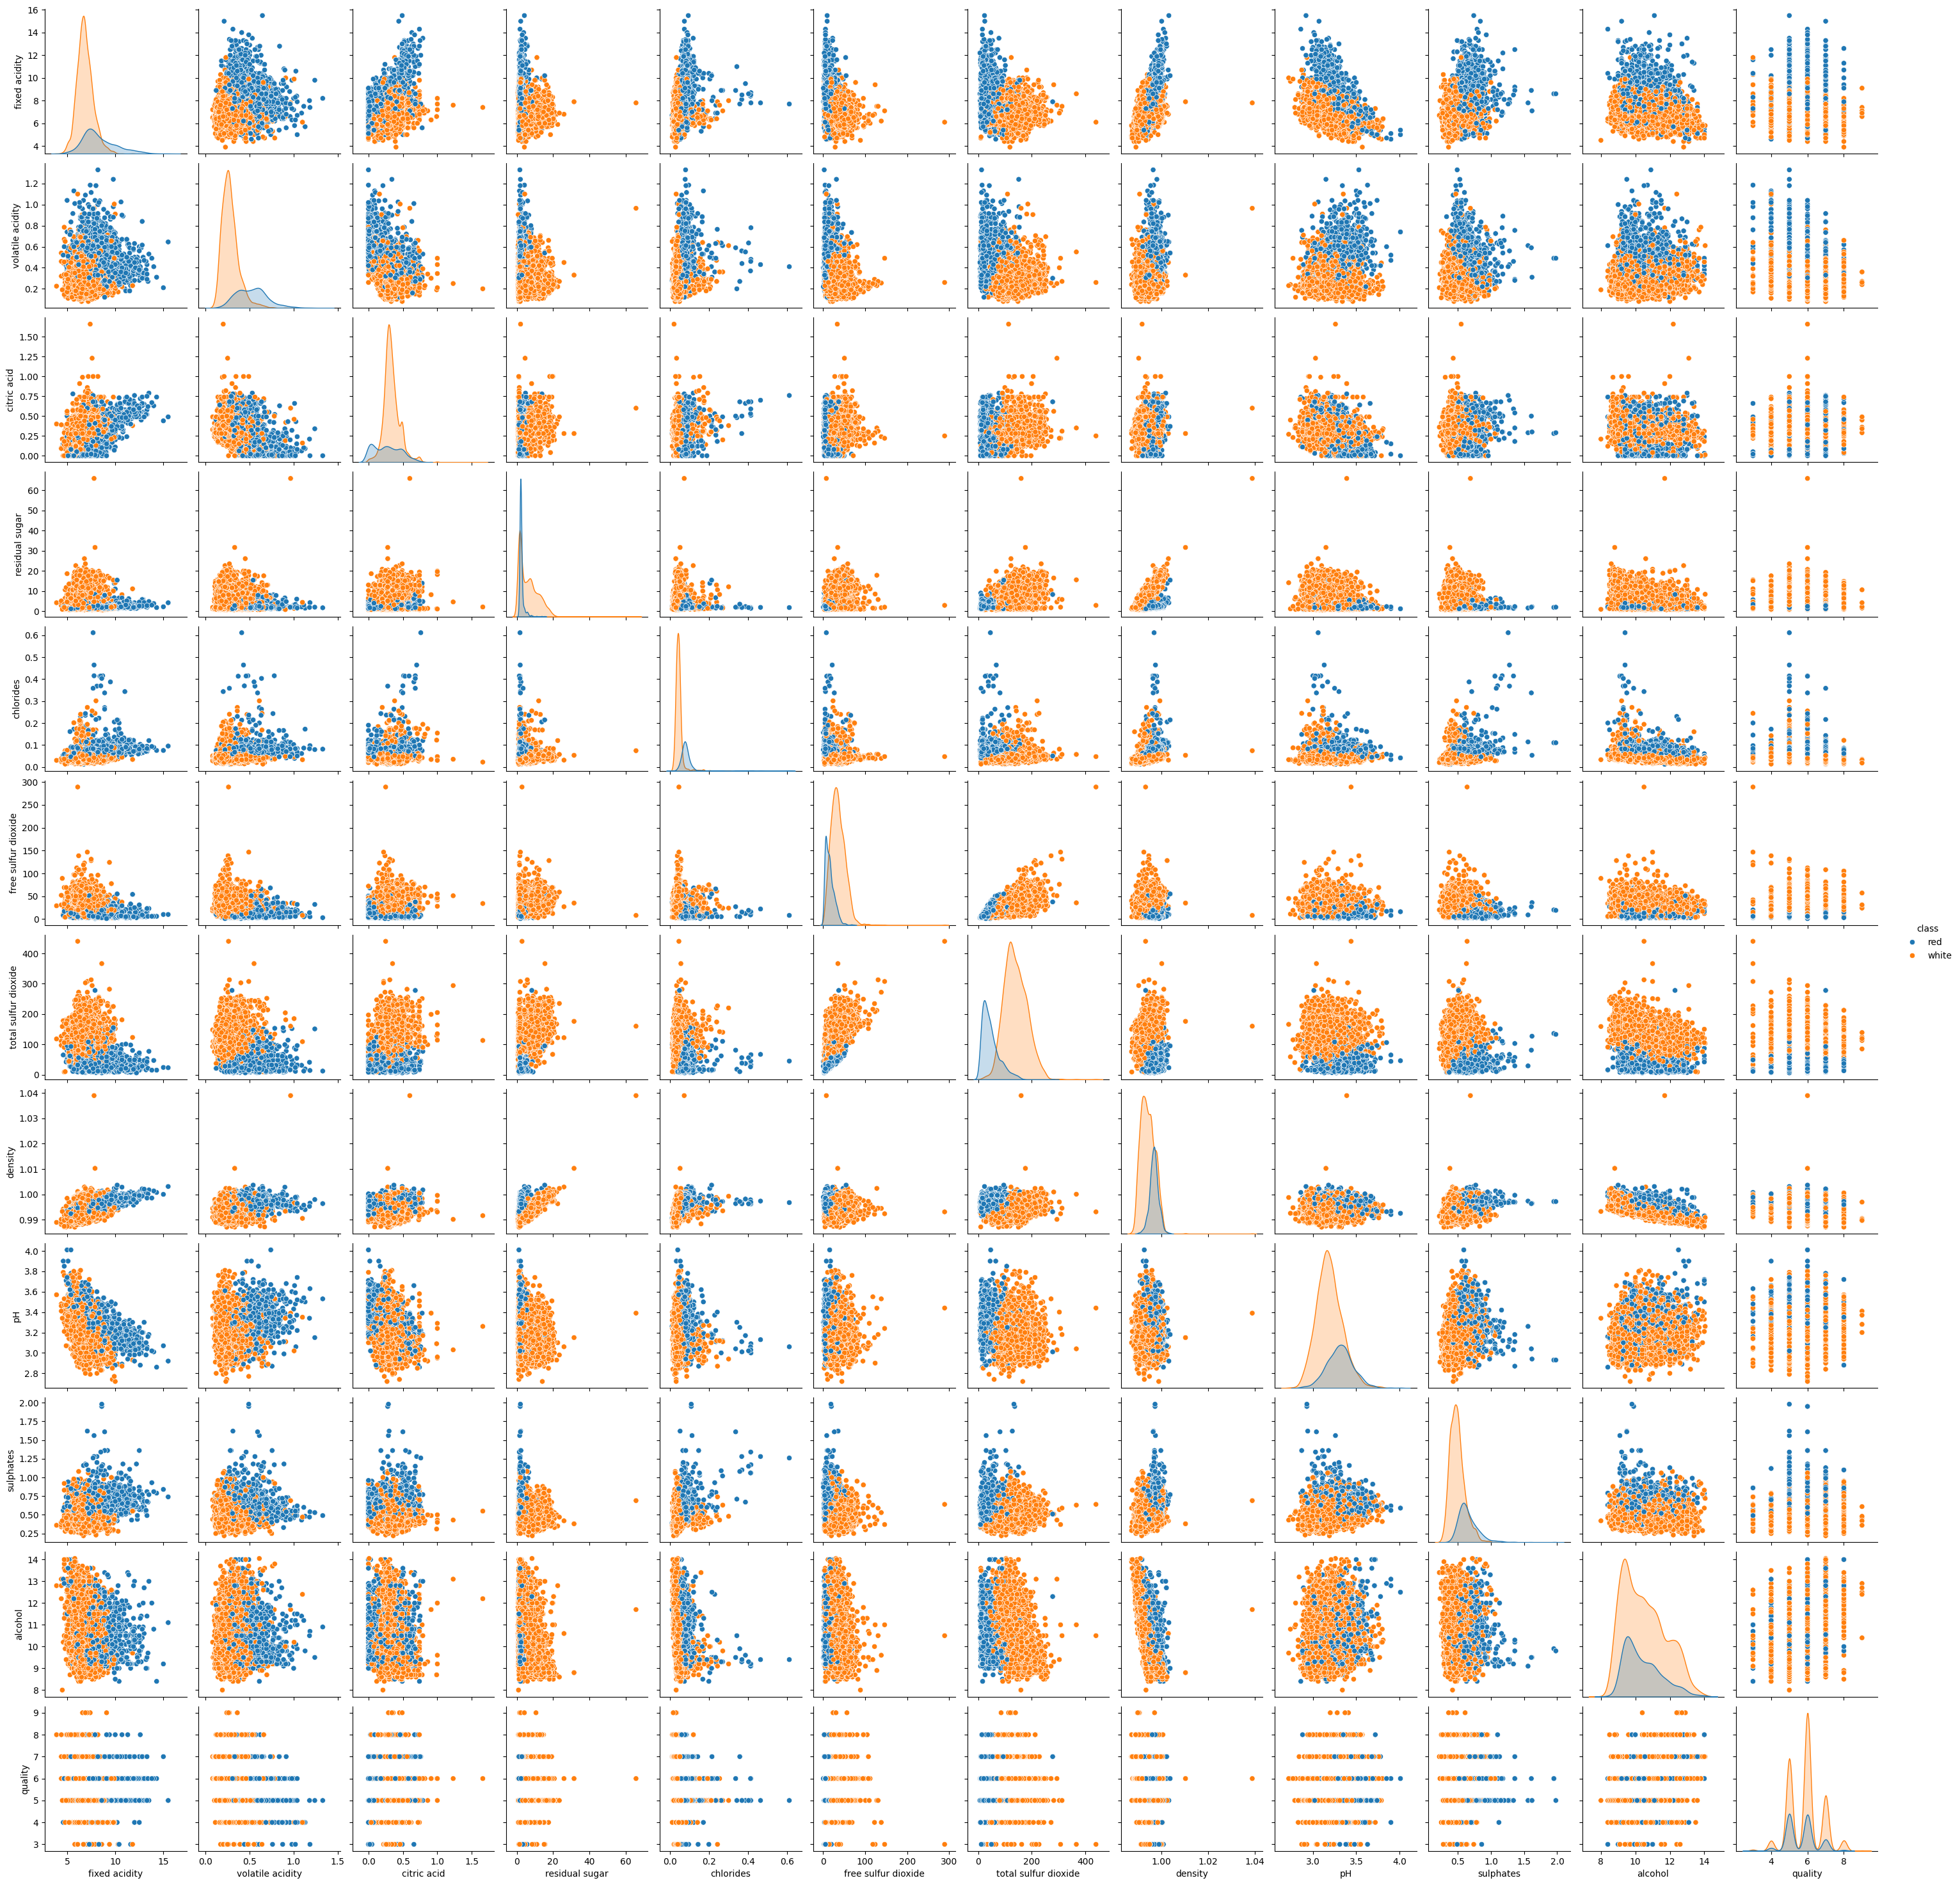

In [35]:
sns.pairplot(train_set, hue='class', diag_kind='kde')

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

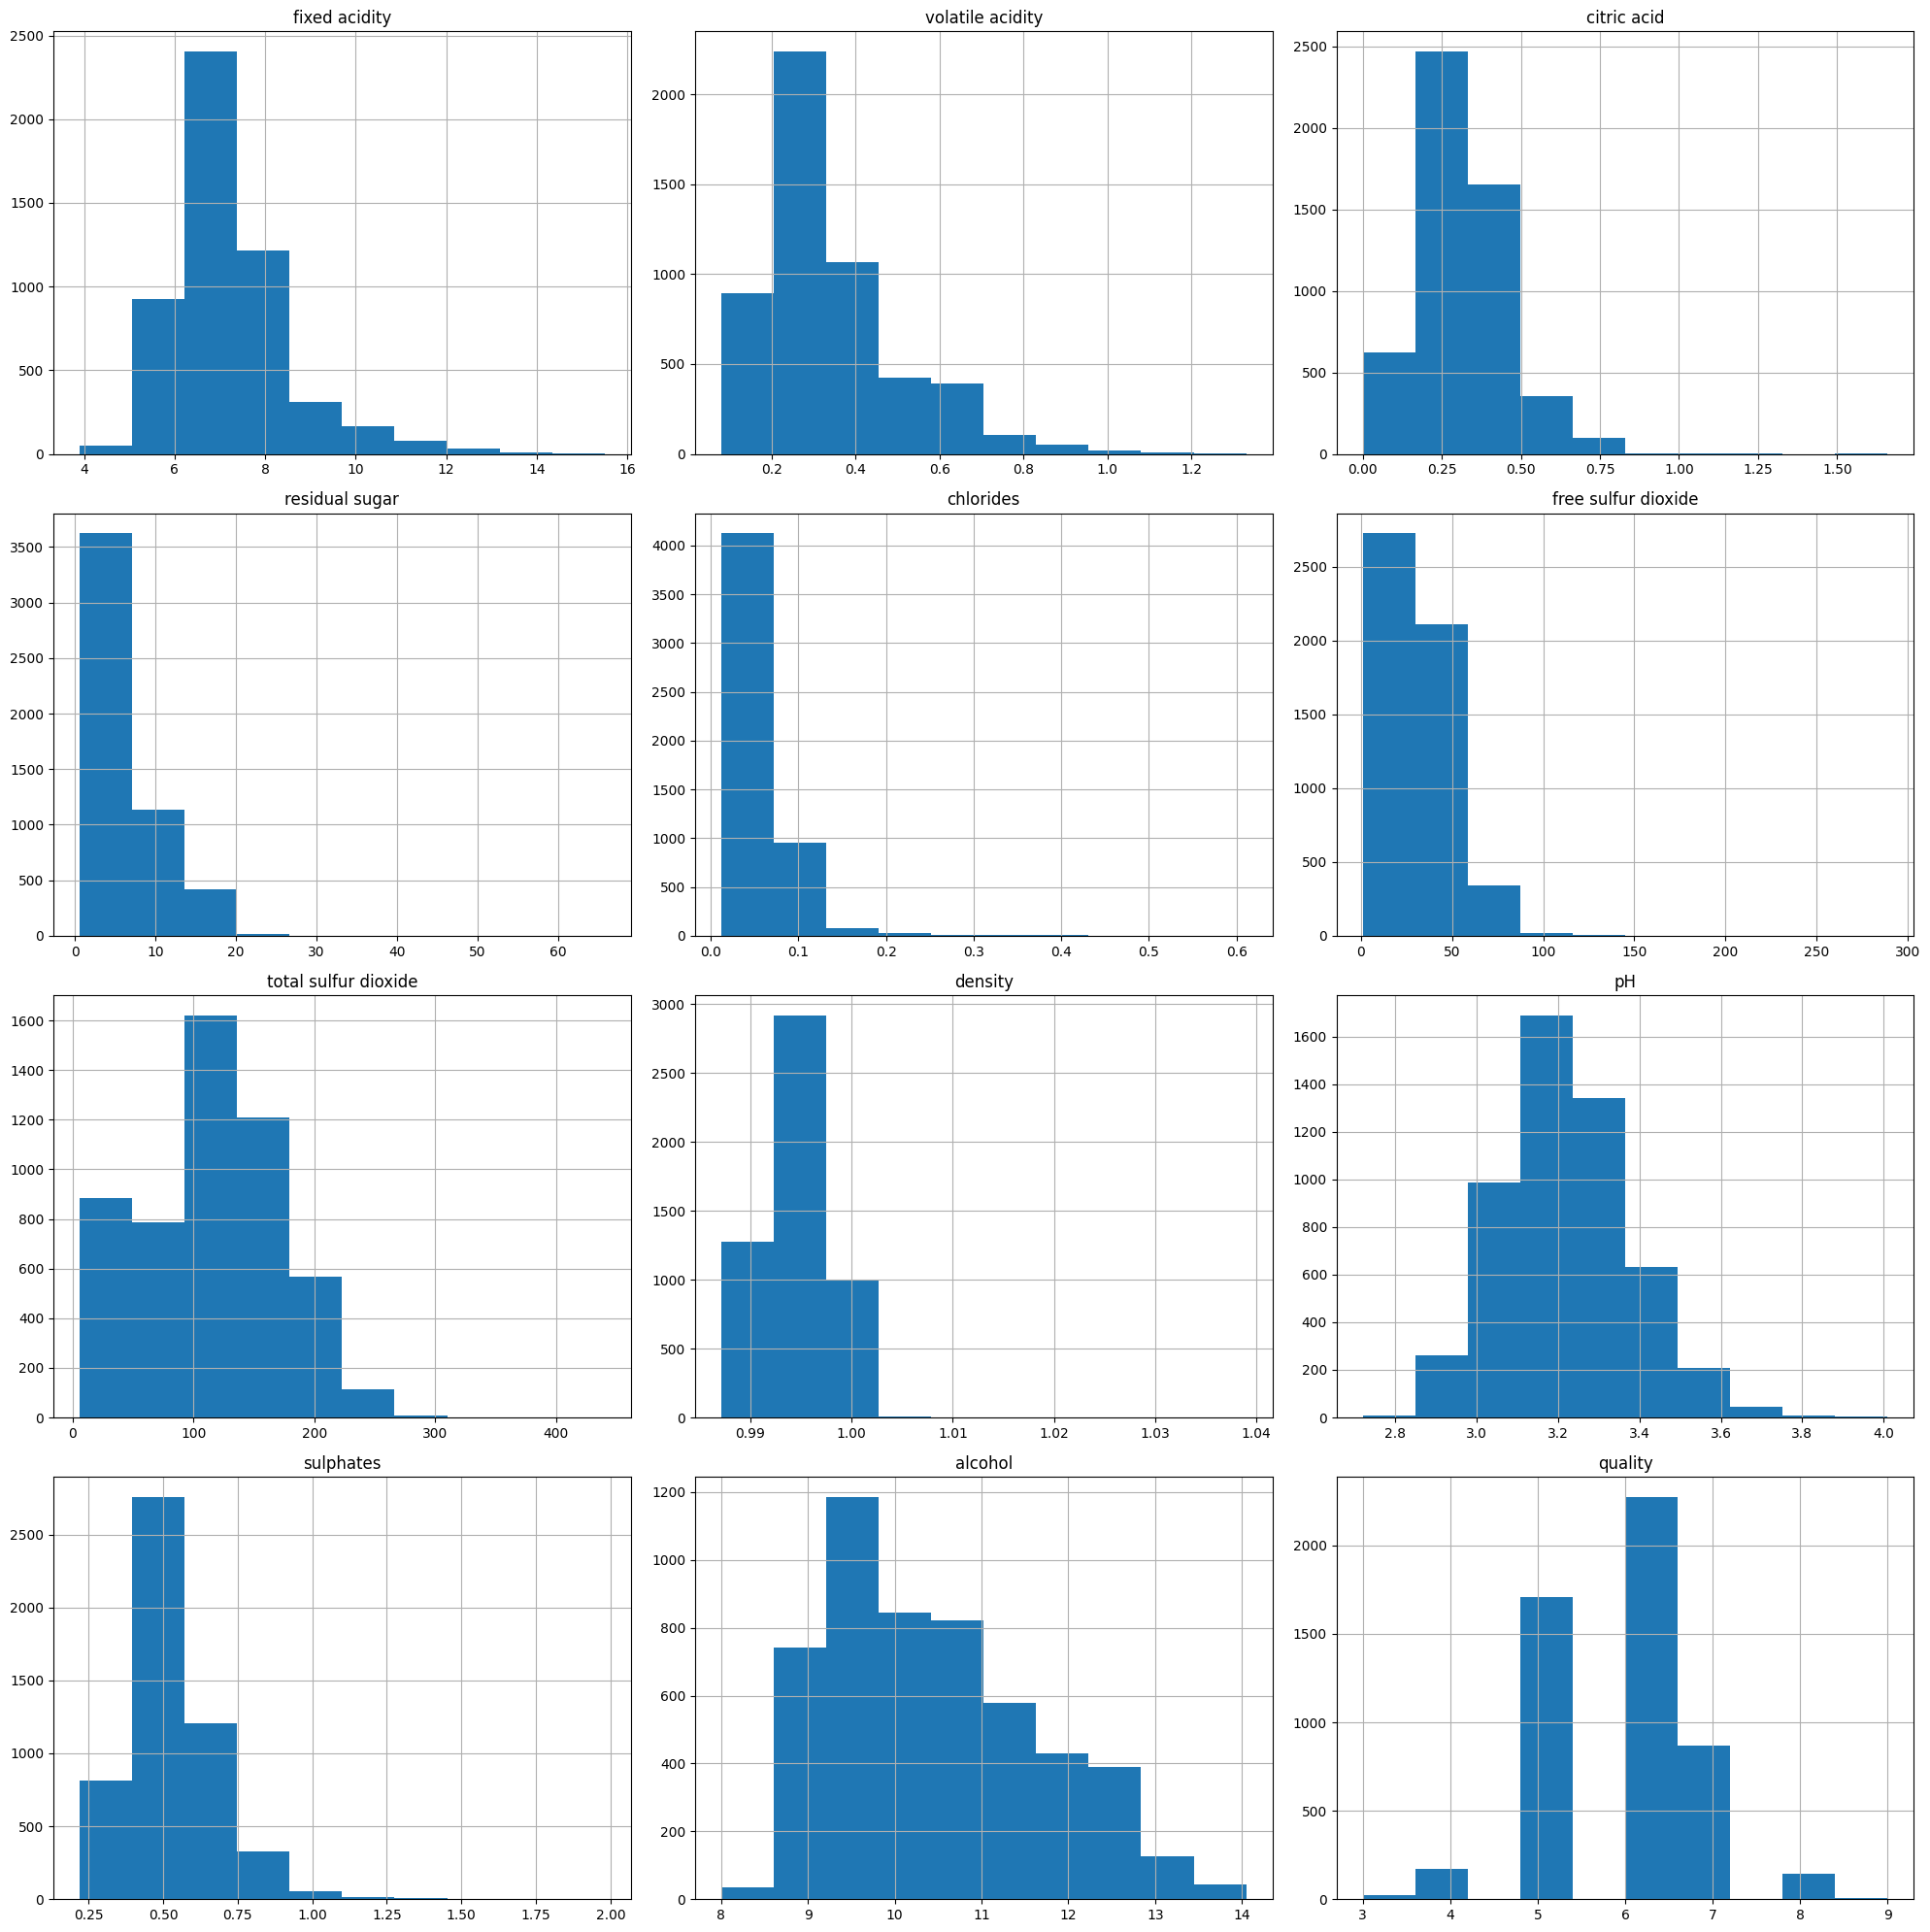

In [43]:
train_set[features_num].hist(figsize = (20,20))
plt.tight_layout()

In [23]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)


In [45]:
features_to_transform = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol', 'quality']

In [46]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [47]:
for col in features_to_transform:
    desplaza = 0 
    if train_set_scaled[col].min() <= 0:
        desplaza = int(abs(train_set_scaled[col].min())) + 1
    train_set_scaled[col] = np.log(train_set_scaled[col] + desplaza)
    test_set_scaled[col] = np.log(test_set_scaled[col] + desplaza)

In [48]:
scaler = StandardScaler()
train_set_scaled[features_num] = scaler.fit_transform(train_set_scaled[features_num])
test_set_scaled[features_num] = scaler.transform(test_set_scaled[features_num])

In [51]:
y_train = (train_set[target_c] == "M").astype(int) # Clase 0 -> B, Clase 1 -> M
y_test = (test_set[target_c] == "M").astype(int) 


X_train_dict = {}
X_test_dict = {}

features_set_name = ["reducido","sin_num_2","todos"]

for set_name,feature_list in zip(features_set_name, [features_to_transform,features_num]):
    # Recuerda que features_num ya contiene features_num_2 por eso la usamos al final, para considerar todas las features
    X_train_dict[set_name] = train_set[feature_list]
    X_test_dict[set_name] = test_set[feature_list]

X_train_dict_scaled = {}
X_test_dict_scaled = {}

for set_name,feature_list in zip(features_set_name, [features_to_transform,features_num]):
    # Recuerda que features_num ya contiene features_num_2 por eso la usamos al final, para considerar todas las features
    X_train_dict_scaled[set_name] = train_set_scaled[feature_list]
    X_test_dict_scaled[set_name] = test_set_scaled[feature_list]

In [62]:

X = df.drop('class', axis=1) 
y = df['class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [54]:
lr_clf = LogisticRegression(max_iter = 1000)
rf_clf = RandomForestClassifier(max_depth= 6, random_state= 42)
lgb_clf = LGBMClassifier(max_depth= 6, random_sate = 42, verbose = -100)
xgb_clf = XGBClassifier(max_depth = 6, random_state = 42)
knn_clf = knn_clf = KNeighborsClassifier(n_neighbors=5)

modelos = {
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "Lightgbm": lgb_clf,
    "XGBoost": xgb_clf,
    "KNN": knn_clf
    
}

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, recall_score

scoring_func = make_scorer(recall_score, average='macro')

for nombre_modelo, modelo in modelos.items():
    scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring=scoring_func)
    print(f"{nombre_modelo}: Recall Medio - {np.mean(scores)}")

Regresion Logistica: Recall Medio - 0.9903246283799814
Random Forest: Recall Medio - 0.989410644198229
Lightgbm: Recall Medio - 0.9930268935291039


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\enrik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\enrik\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\enrik\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1471, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['red' 'white']


In [64]:
from sklearn.model_selection import RandomizedSearchCV

# Define el espacio de búsqueda de hiperparámetros para RandomForest
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(rf_clf, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, scoring=scoring_func)
rf_random.fit(X_train, y_train)

print("Mejores hiperparámetros:", rf_random.best_params_)
print("Recall Medio con los mejores hiperparámetros:", rf_random.best_score_)


c:\Users\enrik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\enrik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\enrik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\enrik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py

Mejores hiperparámetros: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Recall Medio con los mejores hiperparámetros: 0.989542159151231


In [65]:
mejor_modelo = rf_random.best_estimator_  # Utiliza tu mejor modelo aquí

# Entrenar el mejor modelo en el conjunto de entrenamiento completo
mejor_modelo.fit(X_train, y_train)

# Evaluación en el conjunto de prueba
y_pred = mejor_modelo.predict(X_test)

# Análisis de errores
from sklearn.metrics import confusion_matrix, classification_report

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Matriz de Confusión:
[[300   9]
 [  2 989]]

Reporte de Clasificación:
              precision    recall  f1-score   support

         red       0.99      0.97      0.98       309
       white       0.99      1.00      0.99       991

    accuracy                           0.99      1300
   macro avg       0.99      0.98      0.99      1300
weighted avg       0.99      0.99      0.99      1300



### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [69]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'class'],
      dtype='object')

In [70]:
target_r = 'alcohol'

<Axes: xlabel='alcohol', ylabel='Count'>

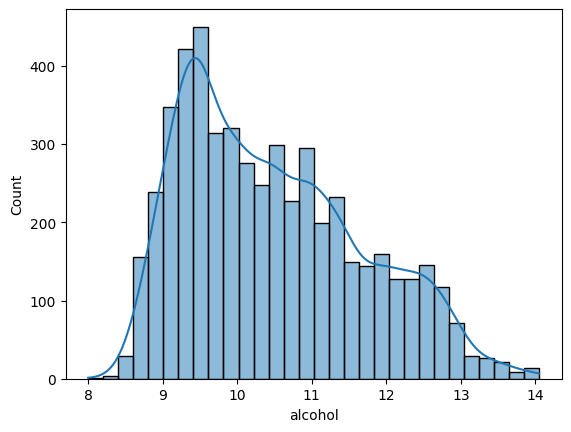

In [71]:
sns.histplot(train_set[target_r], kde = True)

In [73]:
corr = train_set.corr(numeric_only= True)
np.abs(corr[target_r]).sort_values(ascending = False)

alcohol                 1.000000
density                 0.682345
quality                 0.450403
residual sugar          0.357459
total sulfur dioxide    0.272970
chlorides               0.260508
free sulfur dioxide     0.188460
pH                      0.116497
fixed acidity           0.091964
volatile acidity        0.036041
citric acid             0.005690
sulphates               0.000412
Name: alcohol, dtype: float64

<Axes: >

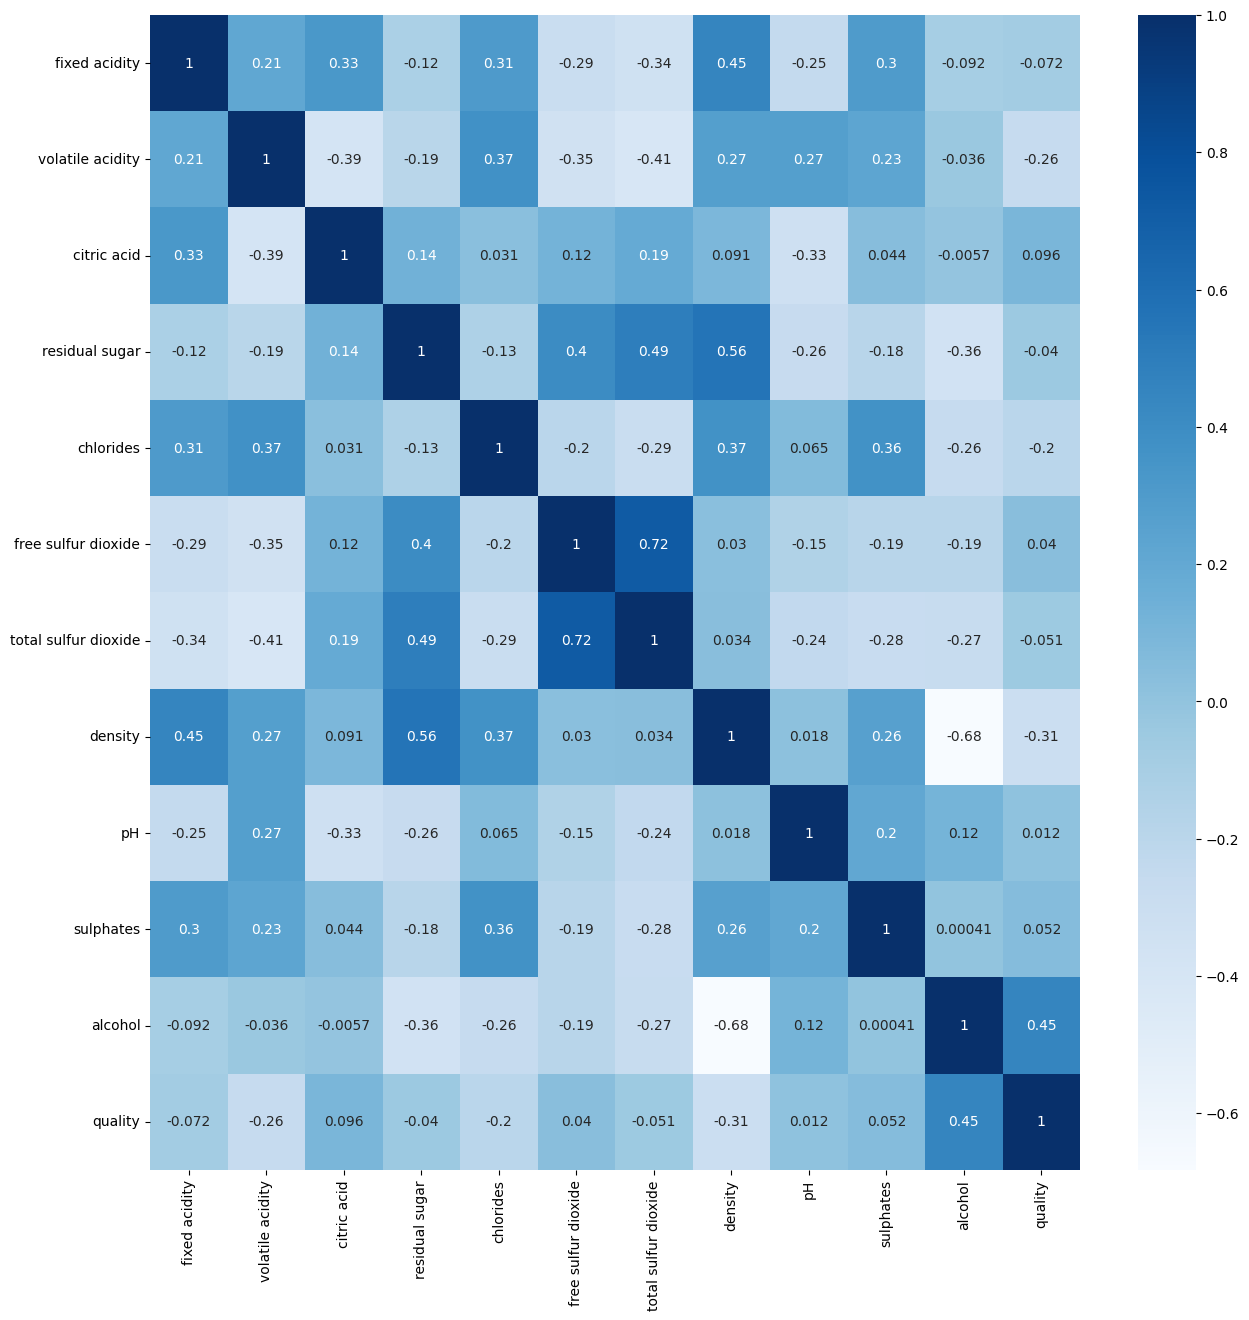

In [74]:

plt.figure(figsize = (15,15))
sns.heatmap(corr, annot= True, cmap = "Blues")

In [78]:
y_train = train_set[target_r]
y_test = test_set[target_r]

features_set_names = ["reducido", "alta_correlacion", "completo"]

X_train_dict = {}
X_test_dict = {}

for nombre in features_set_names:
    X_train_dict[nombre] = train_set.drop(target_r, axis=1)  # Usa todas las columnas excepto la columna objetivo
    X_test_dict[nombre] = test_set.drop(target_r, axis=1)


In [79]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42) # El número de niveles para "probar" lo pongo más alto que en clasificación porque el rango de valores de la target es mucho mayor
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)
lgb_reg = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -100)


modelos = {
    "Random Forest": rf_reg,
    "Lightgbm": lgb_reg,
    "XGBoost": xgb_reg
}

In [84]:
for feature_set, X_train in X_train_dict.items():
    # Obtener las columnas categóricas en el conjunto de entrenamiento
    categorical_columns = X_train.select_dtypes(include=['object']).columns

    # Aplicar one-hot encoding solo a las columnas categóricas
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)

    print(f"Para el set {feature_set}:")
    for tipo, modelo in modelos.items():
        print(f"{tipo}: ", end=" ")
        print(np.mean(cross_val_score(modelo, X_train_encoded, y_train, cv=5, scoring="neg_mean_absolute_error")))
    print("******")


Para el set reducido:
Random Forest:  -0.3230983401451199
Lightgbm:  -0.2820208900993424
XGBoost:  -0.2579141124670481
******
Para el set alta_correlacion:
Random Forest:  -0.3230983401451199
Lightgbm:  -0.2820208900993424
XGBoost:  -0.2579141124670481
******
Para el set completo:
Random Forest:  -0.3230983401451199
Lightgbm:  -0.2820208900993424
XGBoost:  -0.2579141124670481
******


In [88]:

from sklearn.compose import ColumnTransformer

# Selecciona las columnas categóricas en tu conjunto de datos
categorical_columns = X_train_dict[features_set_names[1]].select_dtypes(include=['object']).columns

# Crea un transformador para aplicar one-hot encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

# Aplica la transformación al conjunto de entrenamiento
X_train_encoded = preprocessor.fit_transform(X_train_dict[features_set_names[1]])

# Continúa con el ajuste del modelo utilizando X_train_encoded
rf_grid.fit(X_train_encoded, y_train_encoded)

X_test_encoded = preprocessor.transform(X_test_dict[features_set_names[1]])




In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_test_processed = preprocessor.transform(X_test_dict[features_set_names[1]])

# Realiza la predicción utilizando el modelo entrenado
y_pred = rf_grid.best_estimator_.predict(X_test_processed)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 26.184072131169287
RMSE: 33.16575065915828


In [93]:

def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

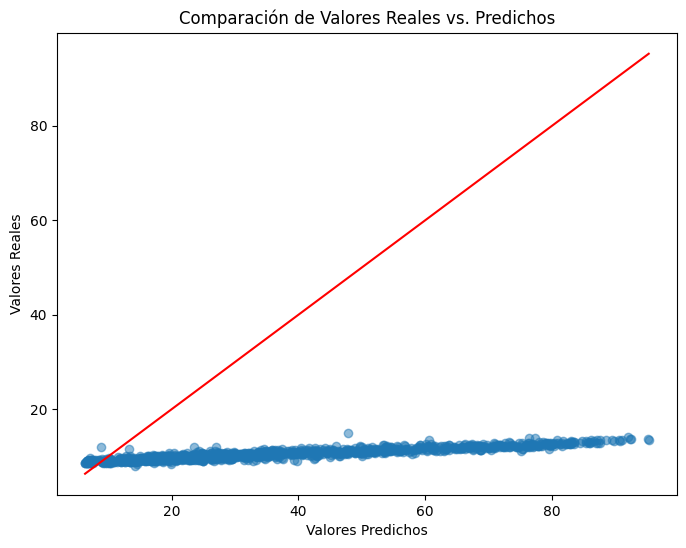

In [94]:
plot_predictions_vs_actual(y_test, y_pred)